In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

Read data

In [2]:
df1 = pd.read_csv("einar_siri_fixation.tsv", sep='\t')
df2 = pd.read_csv("fixation_data_final.tsv", sep='\t')
df = df1.append(df2)
df.head()


,Recording timestamp,Computer timestamp,Sensor,Project name,Participant name,Recording name,Recording duration,Timeline name,Recording Fixation filter name,Recording software version,...,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Viewport position X,Viewport position Y,Viewport width,Viewport height,Mouse position X,Mouse position Y
0,0,1022924105192,NaN,Gaze_model1,Einar,Recording3,169944,Timeline1,Tobii I-VT (Fixation),1.145.28180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12438,1022924117630,Mouse,Gaze_model1,Einar,Recording3,169944,Timeline1,Tobii I-VT (Fixation),1.145.28180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-915.0,486.0
2,28861,1022924134053,Mouse,Gaze_model1,Einar,Recording3,169944,Timeline1,Tobii I-VT (Fixation),1.145.28180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-924.0,477.0
3,44674,1022924149866,Mouse,Gaze_model1,Einar,Recording3,169944,Timeline1,Tobii I-VT (Fixation),1.145.28180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-926.0,473.0
4,94205,1022924199397,Eye Tracker,Gaze_model1,Einar,Recording3,169944,Timeline1,Tobii I-VT (Fixation),1.145.28180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataframe consists of 79 columns! As such we have to perform a bit of cleaning:

In [3]:
cols_to_keep = ['Recording timestamp', 'Participant name', 'Recording name', 'Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)','Eye movement type', 'Eye movement type index','Gaze event duration', 'Presented Media name']
df = df[cols_to_keep]

A big part of the data consists of the calibration part of the experiments.
This has to be discarded, which we do by only keeping the rows where the participant looks at the picture in the experiment.

In [4]:
df = df[df["Presented Media name"] == 'test1.png']
df = df[df["Eye movement type"] == "Saccade"]

### Saccade duration
Since our aim is to look at each saccade, we need to keep just one row for each invidual saccade.
They are organized by `'Eye movement type index'`. Because different recordings can contain the same eye movement indices, we only discard the ones that are consecutively identical.

In [5]:
unique_saccades = df[df['Eye movement type index'] != df['Eye movement type index'].shift(1)]
unique_saccades.head()

,Recording timestamp,Participant name,Recording name,Gaze point X (MCSnorm),Gaze point Y (MCSnorm),Eye movement type,Eye movement type index,Gaze event duration,Presented Media name
4856,39774492,Einar,Recording3,"0,4637","0,3981",Saccade,450.0,17.0,test1.png
4860,39807782,Einar,Recording3,"0,4594","0,3624",Saccade,451.0,17.0,test1.png
4913,40199429,Einar,Recording3,"0,4550","0,3947",Saccade,452.0,17.0,test1.png
4917,40224416,Einar,Recording3,"0,4693","0,4393",Saccade,453.0,8.0,test1.png
4920,40249457,Einar,Recording3,"0,4602","0,3961",Saccade,454.0,17.0,test1.png


Histograms of saccade duration

array([[<AxesSubplot:title={'center':'Gaze event duration'}>]],
      dtype=object)

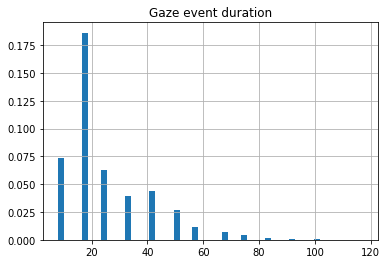

In [8]:
unique_saccades.hist(column='Gaze event duration', bins=50, density=True)


Now we can try to find an exponential distribution that corresponds to the duration data.

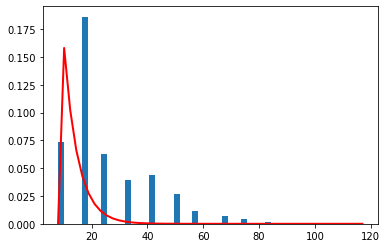

0.8436369094574669 7.999999999999998 10


In [11]:
from scipy.stats import gamma
from scipy import special as sps
shape, loc, scale = gamma.fit(unique_saccades['Gaze event duration'])
s = np.random.gamma(2, 2, size=10000)
count, bins, ignored = plt.hist(unique_saccades['Gaze event duration'], bins=50, density=True)
pdf_gamma = gamma.pdf(bins, 1, 9, 5)


plt.plot(bins, pdf_gamma, linewidth=2, color='r')  

plt.show()
print(shape, loc, 10)

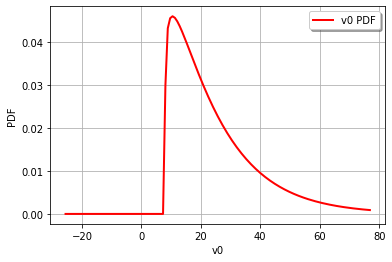

In [12]:
import openturns as ot
import openturns.viewer as otv

gammaDistribution = ot.Gamma()
sample = gammaDistribution.getSample(100)


gamma_data = np.array([(i, v) for i, v in enumerate(unique_saccades['Gaze event duration'])])

durations = ot.Sample([[ui] for ui in unique_saccades['Gaze event duration']])

distribution = ot.GammaFactory().build(durations)
otv.View(distribution.drawPDF())

### Distance travelled during saccades
Next up is to analyze the average distance from the beginning to the end of a saccade. We will use this to calibrate our $D$ value.

First we need to filter out data so that we end up with the first and last row. We do this by doing the same operation as last time, but this time keeping the last row associated with every 'Eye movement type index'. We then add this to the dataframe with the first row.

In [13]:
import numpy as np
saccades = unique_saccades.append(df[df['Eye movement type index'] != df['Eye movement type index'].shift(-1)])
saccades.sort_index(inplace=True)

We also need to remove all 'Eye movement type index' where the first or last row contains invalid data for the gaze point.

In [14]:
# Find all rows where Gaze X or Gaze Y is 'nan'
gaze_point_cols = ['Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)']
nan = saccades[gaze_point_cols].isna()

# Create a mask for all rows with an 'Eye movement index' that contains 'nan', with matching 'Participant name'
nan_indices = saccades[nan['Gaze point X (MCSnorm)']][['Eye movement type index', 'Participant name']]

msk = np.zeros(len(saccades), dtype=bool)

for part in nan_indices['Participant name'].unique():
    invalid_ids = nan_indices[nan_indices['Participant name'] == part]['Eye movement type index'].values
    part_mask = (saccades['Participant name'] == part) & (saccades['Eye movement type index'].isin(invalid_ids))
    msk = np.logical_or(msk, part_mask)

# Check saccade rows that matches the mask
saccades[msk]

,Recording timestamp,Participant name,Recording name,Gaze point X (MCSnorm),Gaze point Y (MCSnorm),Eye movement type,Eye movement type index,Gaze event duration,Presented Media name
9030,74493242,Sigve,Recording3,"0,6773","0,0213",Saccade,352.0,33.0,test1.png
9033,74518332,Sigve,Recording3,NaN,NaN,Saccade,352.0,33.0,test1.png
9035,74534907,Sigve,Recording3,NaN,NaN,Saccade,353.0,8.0,test1.png
9035,74534907,Sigve,Recording3,NaN,NaN,Saccade,353.0,8.0,test1.png
9038,74559907,Sigve,Recording3,NaN,NaN,Saccade,354.0,25.0,test1.png
9040,74576612,Sigve,Recording3,"0,6533","0,0173",Saccade,354.0,25.0,test1.png
9059,74731948,Sigve,Recording3,NaN,NaN,Saccade,355.0,24.0,test1.png
9061,74748283,Sigve,Recording3,NaN,NaN,Saccade,355.0,24.0,test1.png
9066,74789993,Sigve,Recording3,"0,6499","0,0234",Saccade,357.0,17.0,test1.png
9067,74798309,Sigve,Recording3,NaN,NaN,Saccade,357.0,17.0,test1.png


In [15]:
clean_saccades = saccades[~msk]
start = clean_saccades[clean_saccades['Eye movement type index'] != clean_saccades['Eye movement type index'].shift(1)]
end = clean_saccades[clean_saccades['Eye movement type index'] != clean_saccades['Eye movement type index'].shift(-1)]
# convert values from strings to floats
start = [ (float(x.replace(',', '.')), float(y.replace(',', '.'))) for x, y in start[gaze_point_cols].values]
end = [ (float(x.replace(',', '.')), float(y.replace(',', '.'))) for x, y in end[gaze_point_cols].values]

# Calculate distances for each 'Eye movement type index'
distances = []
for s_point, e_point in zip(start, end):
    # np.linalg.norm gives euclidian distance between points
    distance = np.linalg.norm(np.array(e_point) - np.array(s_point))
    distances.append(distance)


Create a dataframe of each unique saccade, and add distance travelled for each saccade to a 'Distance' column

In [16]:
sacc_with_dist = clean_saccades[clean_saccades['Eye movement type index'] != clean_saccades['Eye movement type index'].shift(1)]
sacc_with_dist = sacc_with_dist.assign(Distance=distances)
sacc_with_dist['Distance'].values

array([0.01803469, 0.03911547, 0.02248044, ..., 0.03270352, 0.02088923,
       0.04641648])

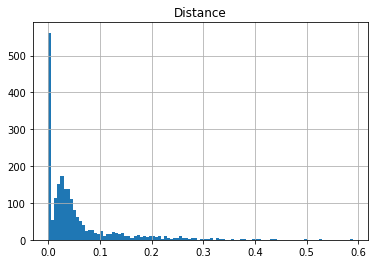

In [17]:
sacc_with_dist.hist(column='Distance', bins=100)
plt.show()

0.001721801943777692

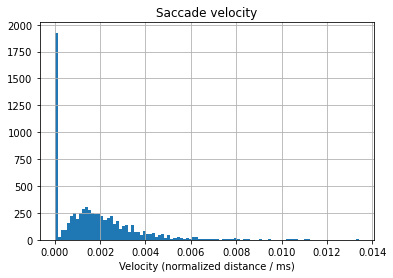

In [18]:
sacc_with_dist['Saccade velocity'] = sacc_with_dist['Distance'] / sacc_with_dist['Gaze event duration']
hist, = sacc_with_dist.hist(column='Saccade velocity', bins=100, density=True)
hist[0].set_xlabel('Velocity (normalized distance / ms)')
sacc_with_dist['Saccade velocity'].mean()

avg velocity for Einar: 0.0021692108626025614
avg velocity for Sigve: 0.0021199185356902176
avg velocity for Siri: 0.0025498717550520864
avg velocity for Mathilde: 0.002128123452666831
avg velocity for Pedro: 0.0022421798564821256
avg velocity for Amir: 0.0025821181981955346


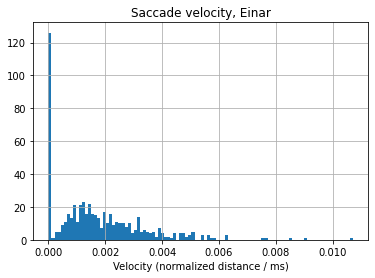

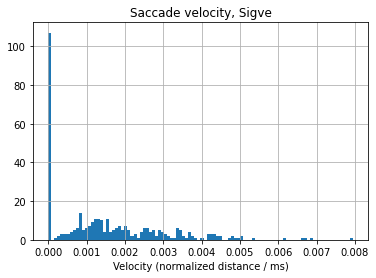

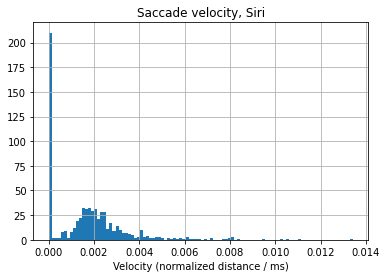

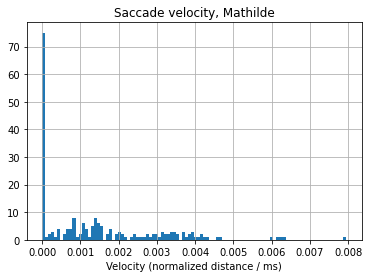

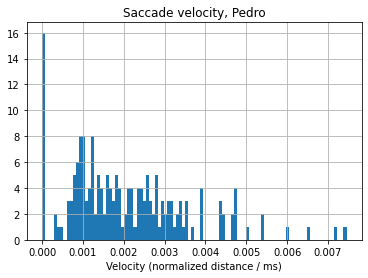

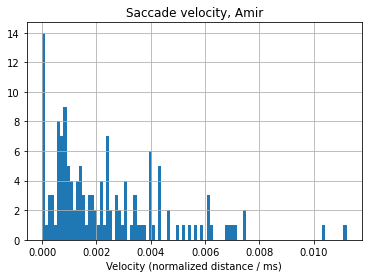

In [19]:
for participant in sacc_with_dist['Participant name'].unique():
    velocity = [ v for v in sacc_with_dist[sacc_with_dist['Participant name'] == participant]['Saccade velocity'].values if v > 0]
    print(f"avg velocity for {participant}: {sum(velocity) / len(velocity)}") 
    hist = sacc_with_dist[sacc_with_dist['Participant name'] == participant].hist(column='Saccade velocity', bins=100)[0][0]
    hist.set_title(f'Saccade velocity, {participant}')
    hist.set_xlabel('Velocity (normalized distance / ms)')